<div style="display: flex;">
    <a href="https://t.me/nsbarsukov" style="margin-right:20px;">
        <img src="https://img.shields.io/badge/Telegram-2CA5E0?style=for-the-badge&logo=telegram&logoColor=white" alt="write-me-telegram"/>
    </a>
    <a href="https://github.com/nsbarsukov/toxic-comments-detector" style="margin-right:20px;">
        <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="Open Github"/>
    </a>
</div>
<div style="display: flex; margin-top: 20px;">
    <a href="https://colab.research.google.com/github/nsbarsukov/toxic-comments-detector/blob/master/models/01simpleNNModel.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
</div>

In [1]:
MODEL_NAME = 'simple_NN_model'

In [2]:
import os

def check_is_google_colab():
    return 'google.colab' in str(get_ipython())


def prepare_environment():
    if check_is_google_colab():
        from google.colab import drive
        import shutil
        
        drive.mount('/content/gdrive/')

        PATH_TO_TEMP_REPO = '/content/gdrive/My Drive/toxic-comments-repo-temp'

        try:
            shutil.rmtree(PATH_TO_TEMP_REPO)
        except:
            pass

        os.mkdir(PATH_TO_TEMP_REPO)
        
        %cd ./gdrive/My Drive/toxic-comments-repo-temp
        ! git clone https://github.com/nsbarsukov/toxic-comments-detector.git .
        ! pip3 install -q tensorflow_text
    else:
        %cd ..

prepare_environment()

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [3]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    evaluate_model,
    show_tf_model_summary,
    get_3d_quartile_words_count,
    save_tf_model,
    SEED,
    VALIDATION_SPLIT_PARTITION,
    DEFAULT_BATCH_SIZE,
    DEFAULT_EPOCHS,
)

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


## Train model

In [4]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers, losses

In [6]:
MAX_FEATURES = 10000
MAX_SEQUENCE_LENGTH = get_3d_quartile_words_count(X_train.flatten())

vectorize_layer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)
vectorize_layer.adapt(X_train)

In [7]:
model = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string, name='Raw_text'),
    vectorize_layer,
    layers.Embedding(
        input_dim = len(vectorize_layer.get_vocabulary()),
        output_dim = 100
    ),
    layers.GlobalAveragePooling1D(),
    
    layers.Dense(units=128, activation='relu', name='FC_Layer_Relu'),
    layers.Dropout(rate=0.5, seed=SEED, name='Regularization'),
    layers.Dense(
        units=1,
        name='FC_Layer_sigmoid',
        activation='sigmoid'
    ),
], name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [8]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH_SIZE,
    validation_split=VALIDATION_SPLIT_PARTITION, # сколько от тестовой выборки отрезать под валидационную
)

Epoch 1/10
19/19 [==============================] - 2s 66ms/step - loss: 0.6829 - binary_accuracy: 0.6136 - recall: 0.1884 - precision: 0.3844 - val_loss: 0.6506 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 0s 17ms/step - loss: 0.6427 - binary_accuracy: 0.6616 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6137 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 0s 18ms/step - loss: 0.5998 - binary_accuracy: 0.6652 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.5649 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 0s 18ms/step - loss: 0.5510 - binary_accuracy: 0.6630 - recall: 0.0142 - precision: 0.7847 - val_loss: 0.5128 - val_binary_accuracy: 0.7016 - val_recall: 0.1159 - val_precision: 0.9082
Epoch 5/10
1

# Model evaluation

Accuracy: 89.14%
Recall: 77.67%
Precision: 88.11%
F1-score: 82.56% 



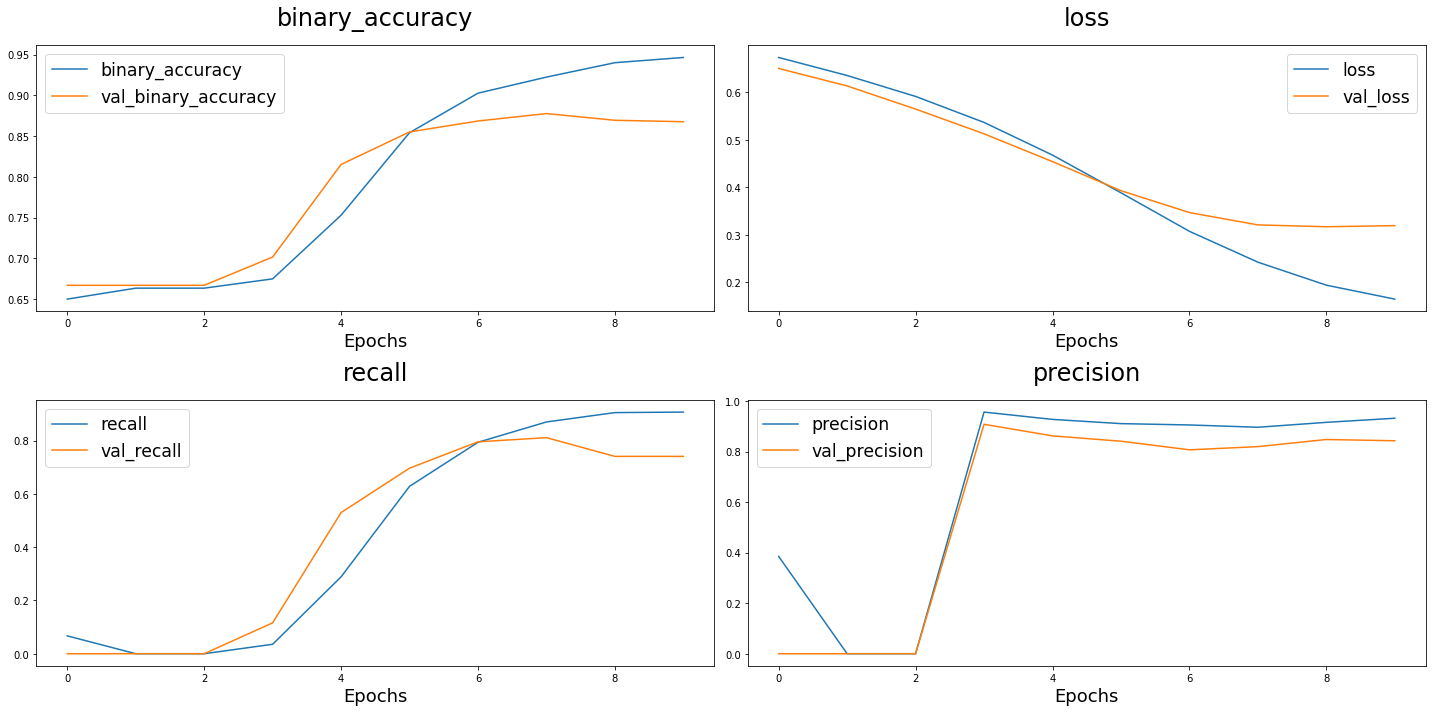

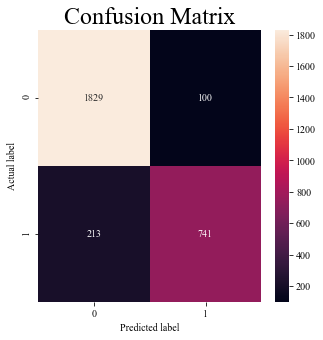

In [9]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, tf_history_learning=history, model_name=MODEL_NAME)

Model: "simple_NN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 31)                0         
_________________________________________________________________
embedding (Embedding)        (None, 31, 100)           1000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
FC_Layer_Relu (Dense)        (None, 128)               12928     
_________________________________________________________________
Regularization (Dropout)     (None, 128)               0         
_________________________________________________________________
FC_Layer_sigmoid (Dense)     (None, 1)                 129       
Total params: 1,013,057
Trainable params: 1,013,057
Non-trainable params: 0
_________________________________________

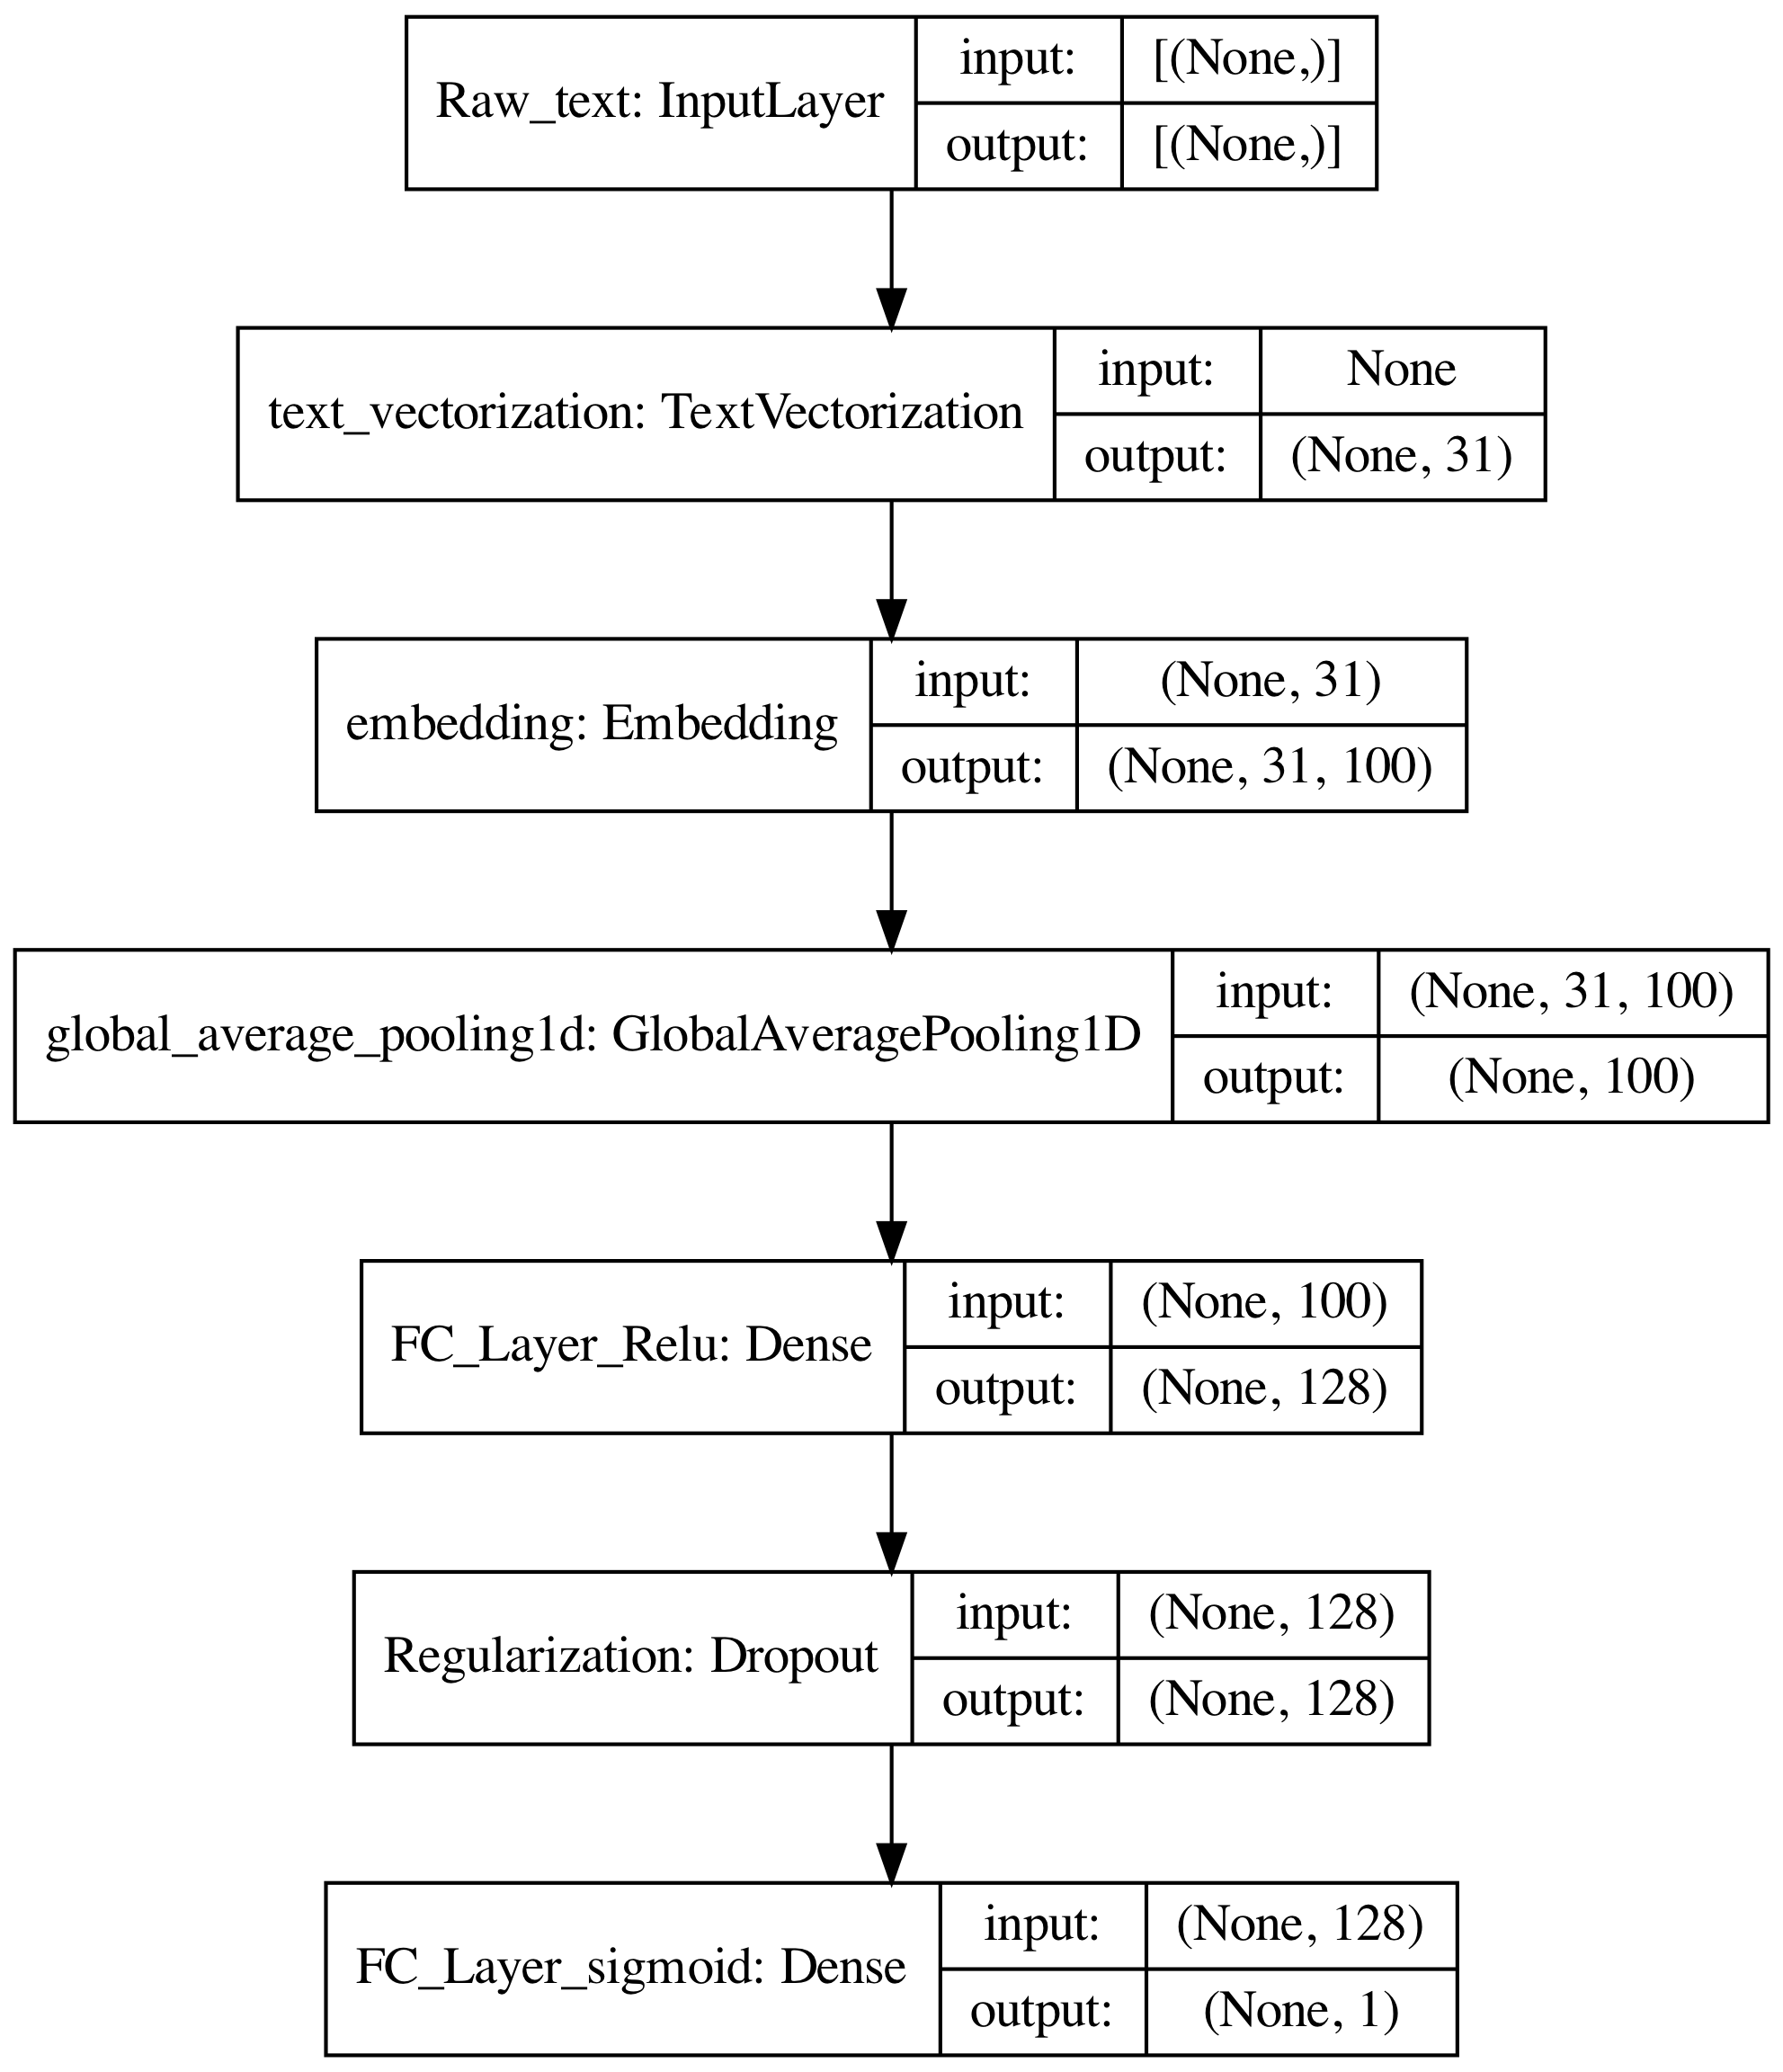

In [10]:
show_tf_model_summary(model)

In [11]:
save_tf_model(model)

INFO:tensorflow:Assets written to: .savedModels/simple_NN_model/assets


In [12]:
from dev import DIRECTORY_WITH_SAVED_MODELS
from textPreprocessing import preprocess_text

loaded_model = tf.keras.models.load_model(f'{DIRECTORY_WITH_SAVED_MODELS}/{model.name}')

raw_texts = ['ты чего берега попутал?', 'это правый берег реки, не путай с левым']
preprocessed_texts = list(map(preprocess_text, raw_texts))

loaded_model.predict(preprocessed_texts)

array([[0.6239096 ],
       [0.02549598]], dtype=float32)